<a href="https://colab.research.google.com/github/sgr1118/PoC-Lab/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 감정 분석(Sentiment Analysis)

* 감정 분석은 텍스트에 등장하는 단어들을 통해 어떤 감정이 드러나는지 분석하는 기법
* 감정 분석은 오피니언 마이닝으로도 불리며, 텍스트에 담긴 의견, 태도 등을 알아보는데 유용한 기법
* 감정 분석을 하기 위해선 미리 정의된 감정 어휘 사전이 필요
* 감정 어휘 사전에 포함된 어휘가 텍스트에 얼마나 분포하는지에 따라 해당 텍스트의 감정이 좌우
* 토픽 모델링이 텍스트의 주제를 찾아낸다면, 감정 분석은 텍스트의 의견을 찾아냄
* 텍스트는 주제(토픽)와 의견(감정)의 결합으로 이루어졌다고 볼 수 있음

![2655364B5925AC9606[1].png](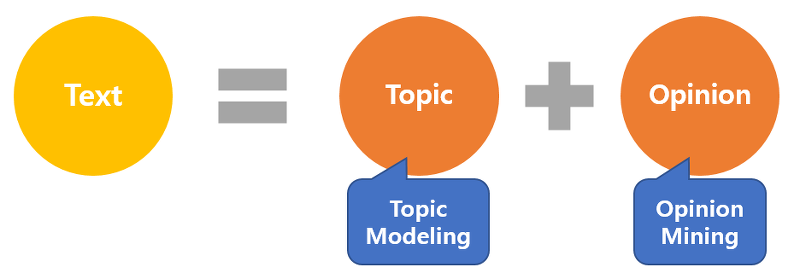)

* 감정 분석은 SNS, 리뷰 분석에 유용하게 사용할 수 있음
* 특정 이슈에 대한 사람들의 감정을 실시간으로 분석한다면, 그에 대해 신속하게 대처 가능

* 파이썬으로 감정 분석하는 방법은 크게 두 가지로 구분
  + 감정 어휘 사전을 이용한 감정 상태 분류
    -  미리 분류해둔 감정어 사전을 통해 분석하고자 하는 텍스트의 단어들을 사전에 기반해 분류하고, 그 감정가를 계산
    - 이 때 사용되는 감정어 사전에는 해당 감정에 해당되는 단어를 미리 정의해둬야 함
  + 기계학습을 이용한 감정 상태 분류
    - 분석 데이터의 일부를 훈련 데이터로 사용해 그로부터 텍스트의 감정 상태를 분류
    - 이 때 사용되는 훈련 데이터는 사용자가 분류한 감정 라벨이 포함되어 있어야 하며,  
이를 인공 신경망, 의사 결정 트리 등의 기계 학습 알고리즘을 사용하여 분류

## 감정 어휘 사전을 이용한 감정 상태 분류

### 감정 사전 준비

*   감정 사전 라이브러리를 설치
*   afinn은 영어에 대한 긍정, 부정에 대한 감정 사전을 제공


In [ ]:
!pip install afinn

### 데이터 준비

1.   사용할 데이터를 구성 
2.   데이터는 사이킷런에 내장되어 있는 뉴스그룹 데이터를 이용

In [2]:
from sklearn.datasets import fetch_20newsgroups

newsdata = fetch_20newsgroups(subset = 'train')
newsdata.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### 감정 상태 분류 및 시각화

*   감정 사전을 구성하고 감정 스코어를 측정
*   afinn 라이브러리는 감정 사전과 더불어 편리하게 감정가를 계산할 수 있는 함수를 제공

In [5]:
from afinn import Afinn

afinn = Afinn()
for i in range(10):
  print(afinn.score(newsdata.data[i]))

7.0
11.0
16.0
5.0
-23.0
-25.0
7.0
3.0
16.0
-20.0


*   모든 뉴스에 대한 감정을 시각화
*   긍정과 부정에 대한 갯수를 시각화



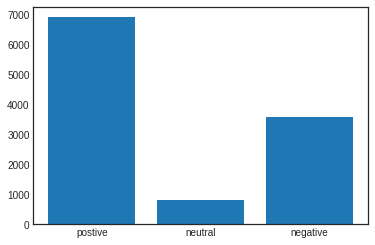

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

postive = 0
neutral = 0
negative = 0

for i in newsdata.data:
  score = afinn.score(i)
  if score > 0:
    postive += 1
  elif score == 0:
    neutral += 1
  else:
    negative += 1

plt.bar(np.arange(3), [postive, neutral, negative])
plt.xticks(np.arange(3), ['postive', 'neutral', 'negative'])
plt.show()

## 기계학습을 이용한 감정 분석

#### 한국어 자연어 처리 konlpy와 형태소 분석기 MeCab 설치

* https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [ ]:
# MeCab 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [10]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
plt.style.use('seaborn-white')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


### 네이버 영화 리뷰 데이터

* 참고: https://wikidocs.net/44249

#### 데이터 로드

* 데이터를 웹에서 바로 받아오기 위해 `urllib.request` 사용
  + https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
  + https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
* 받아온 데이터를 `dataframe`으로 변환하고 데이터를 확인



In [11]:
train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


#### 중복 및 결측치 처리

*   데이터 개수 확인
*   데이터에 중복이 존재한다면 이를 제거



In [13]:
print(train_data['document'].nunique())
print(train_data['label'].nunique())

def preprocessing(df):
  df.drop_duplicates(subset=['document'], inplace=True)
  df = df.dropna(how = 'any', inplace=True)

preprocessing(train_data)

146182
2


In [15]:
# 전처리 결과 확인
print(train_data.isnull().sum())
print(train_data.duplicated(subset='document', keep='first').sum())
print(len(train_data))

id          0
document    0
label       0
dtype: int64
0
146182


#### 데이터 정제



*   데이터에서 한글과 공백을 제외하고 모두 제거



In [17]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


In [18]:
train_data['document'].replace('', np.nan, inplace = True)
print(len(train_data))
print(train_data.isnull().sum())

146182
id            0
document    391
label         0
dtype: int64


In [21]:
train_data = train_data.dropna(how='any')
print(len(train_data))

145791


In [22]:
preprocessing(test_data)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
test_data['document'].replace('', np.nan, inplace = True)
test_data = test_data.dropna(how='any')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


#### 토큰화 및 불용어 제거



* 단어들을 분리하고 불용어를 제거함
* 불용어 사전: `'의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'`



In [23]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [25]:
mecab = Mecab()

X_train = []
for sentence in train_data['document']:
  X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [ ]:
print(X_train[:3])

In [27]:
X_test = []
for sentence in test_data['document']:
  X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

#### 빈도 수가 낮은 단어 제거



*   빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
*   처리를 통해 빈도 수가 낮은 단어들은 제거



In [31]:
threshold = 3

words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value

  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print('전체 단어 수', words_cnt)
print('빈도가 {} 이하인 희귀 단어 수: {}'.format(threshold-1, rare_cnt))
print('희귀 단어 비율 : {}'.format((rare_cnt / words_cnt) * 100))
print('희귀 단어 등장 빈도 비율: {}'.format((rare_freq / words_freq) * 100))

전체 단어 수 49946
빈도가 2 이하인 희귀 단어 수: 28320
희귀 단어 비율 : 56.70123733632323
희귀 단어 등장 빈도 비율: 1.7606788534131563


In [32]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

21628


In [34]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [36]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)

print(len(X_train))
print(len(y_train))

145380
145380


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


#### 패딩



*   리뷰의 전반적인 길이를 확인
*   모델의 입력을 위해 동일한 길이로 맞춰줌



In [37]:
print('리뷰 최대 길이 :', max(len(l) for l in X_train))
print('리뷰 평균 길이 :', sum(map(len, X_train)) / len(X_train))

리뷰 최대 길이 : 83
리뷰 평균 길이 : 13.80136194799835


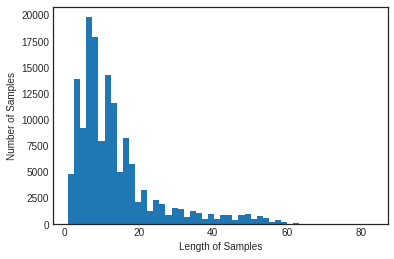

In [39]:
plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [40]:
max_len = 60

In [41]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

#### 모델 구축 및 학습

*   감정 상태 분류 모델을 선언하고 학습
*   모델은 일반적인 LSTM 모델을 사용



In [49]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential

In [53]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         2162800   
                                                                 
 lstm_3 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,280,177
Trainable params: 2,280,177
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(X_train, y_train, epochs = 15, batch_size = 64, validation_split=0.2)

Epoch 1/15
1818/1818 [==============================] - 17s 8ms/step - loss: 0.3838 - acc: 0.8264 - val_loss: 0.3395 - val_acc: 0.8519
Epoch 2/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.2895 - acc: 0.8776 - val_loss: 0.3314 - val_acc: 0.8556
Epoch 3/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.2355 - acc: 0.9028 - val_loss: 0.3489 - val_acc: 0.8592
Epoch 4/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.1921 - acc: 0.9235 - val_loss: 0.3669 - val_acc: 0.8543
Epoch 5/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.1546 - acc: 0.9396 - val_loss: 0.4292 - val_acc: 0.8498
Epoch 6/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.1234 - acc: 0.9521 - val_loss: 0.5217 - val_acc: 0.8440
Epoch 7/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.1010 - acc: 0.9609 - val_loss: 0.5460 - val_acc: 0.8385
Epoch 8/15
1818/1818 [==============================] -

In [55]:
results = model.evaluate(X_test,  y_test)
print('loss : {:.4f}'.format(results[0]), 'accuracy : {:.4f}'.format(results[1]))

1532/1532 [==============================] - 5s 4ms/step - loss: 1.0250 - acc: 0.8328
loss : 1.0250 accuracy : 0.8328


#### 시각화

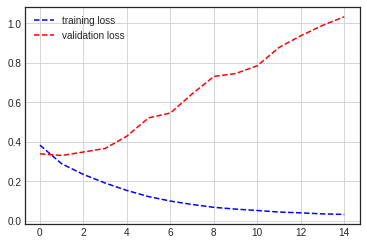

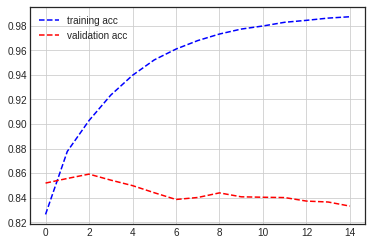

In [56]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label = 'training acc')
plt.plot(val_acc, 'r--', label = 'validation acc')
plt.legend()
plt.grid()

plt.show()

#### 감정 예측

In [183]:
def sentiment_predict(new_sentence):
  new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
  new_sequences = tokenizer.texts_to_sequences([new_token])
  new_pad = pad_sequences(new_sequences, maxlen = max_len)
  score = float(model.predict(new_pad))

  if score >= 0.6:
    print('{} -> 긍정({:.2f}%)'.format(new_sentence, score*100))
  elif (score >= 0.3) and (score < 0.6):
    print('{} -> 보통({:.2f}%)'.format(new_sentence, (1- score)*100))
  else:
    print('{} -> 부정({:.2f}%)'.format(new_sentence, (1-score)*100))

In [206]:
sentence = [
    '감독아 이런걸 영화라고...',
    'n회차 각이다.',
    '누가 영화보라고 칼 들고 협박했음?',
    'ㅋㅋ 장르가 공포가 아니라 코미디임 개웃기네',
    '지구 뿌시고싶은 귀여움ㅜㅜㅜㅜㅜ',
    '이런 띵작은 빨리 봐야지 ㅋㅋㅋㅋ',
    '보다가 중간에 나왔음 ㅋㅋ 못참겠음',
    '아 ㅋㅋ 이건 못 참지~',
    '감독아... 이게 뭐냐...',
    '밥 스튜어트 케빈..귀엽고 귀엽다',
    '송강호의 연기가 영화의 전부였음',
    '2번째 작품은 대부분 망작']

for sen in sentence:
  sentiment_predict(sen)

# 문맥 파악을 할 수 있는 모델이 필요하다!

1/1 [==============================] - 0s 23ms/step
감독아 이런걸 영화라고... -> 보통(68.14%)
1/1 [==============================] - 0s 19ms/step
n회차 각이다. -> 긍정(98.98%)
1/1 [==============================] - 0s 16ms/step
누가 영화보라고 칼 들고 협박했음? -> 부정(100.00%)
1/1 [==============================] - 0s 15ms/step
ㅋㅋ 장르가 공포가 아니라 코미디임 개웃기네 -> 부정(90.72%)
1/1 [==============================] - 0s 15ms/step
지구 뿌시고싶은 귀여움ㅜㅜㅜㅜㅜ -> 긍정(99.99%)
1/1 [==============================] - 0s 15ms/step
이런 띵작은 빨리 봐야지 ㅋㅋㅋㅋ -> 긍정(99.75%)
1/1 [==============================] - 0s 15ms/step
보다가 중간에 나왔음 ㅋㅋ 못참겠음 -> 부정(99.65%)
1/1 [==============================] - 0s 16ms/step
아 ㅋㅋ 이건 못 참지~ -> 부정(97.71%)
1/1 [==============================] - 0s 15ms/step
감독아... 이게 뭐냐... -> 부정(97.32%)
1/1 [==============================] - 0s 16ms/step
밥 스튜어트 케빈..귀엽고 귀엽다 -> 보통(56.80%)
1/1 [==============================] - 0s 16ms/step
송강호의 연기가 영화의 전부였음 -> 긍정(99.43%)
1/1 [==============================] - 0s 16ms/step
2번째 작품은 대부분 망작 -> 보통(43.18%

### 네이버 쇼핑 리뷰 데이터

* 참고: https://wikidocs.net/94600

#### 데이터 로드

In [123]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", 
                           filename="shopping.txt")

('shopping.txt', <http.client.HTTPMessage at 0x7f4ddeb27690>)

In [128]:
total_data = pd.read_table('shopping.txt', names= ['ratings', 'reviews'])
print(len(total_data))

200000


In [129]:
total_data.head(10)

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...


#### 훈련 데이터와 테스트 데이터 분리

In [132]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data.head(10)

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...,0
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...,0
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요,0
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~,0
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...,0


In [133]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [135]:
total_data.drop_duplicates(subset=['reviews'], inplace = True)
print(len(total_data))

199908


In [137]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 111)
print(len(train_data), len(test_data))

149931 49977


#### 레이블의 분포 확인

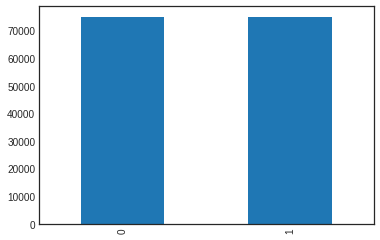

In [139]:
train_data['label'].value_counts().plot(kind='bar')

In [141]:
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,74974
1,1,74957


#### 데이터 정제

In [143]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data['reviews'].replace('', np.nan, inplace = True)
print(len(train_data))

149931


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [144]:
test_data.drop_duplicates(subset=['reviews'], inplace = True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
test_data['reviews'].replace('', np.nan, inplace = True)
print(len(test_data))

49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


#### 토큰화 및 불용어 제거

* 불용어 사전: `'도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게'`

In [145]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [149]:
mecab = Mecab()

train_data['reviews'] = train_data['reviews'].apply(mecab.morphs)
train_data['reviews'] = train_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

In [148]:
test_data['reviews'] = test_data['reviews'].apply(mecab.morphs)
test_data['reviews'] = test_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

In [156]:
X_train = train_data['reviews'].values
y_train= train_data['label'].values
X_test = test_data['reviews'].values
y_test = test_data['label'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(149931,) (149931,)
(49977,) (49977,)


#### 빈도 수가 낮은 단어 제거



*   빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
*   처리를 통해 빈도 수가 낮은 단어들은 제거



In [207]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [208]:
threshold = 3

words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value

  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print('전체 단어 수', words_cnt)
print('빈도가 {} 이하인 희귀 단어 수: {}'.format(threshold-1, rare_cnt))
print('희귀 단어 비율 : {}'.format((rare_cnt / words_cnt) * 100))
print('희귀 단어 등장 빈도 비율: {}'.format((rare_freq / words_freq) * 100))

전체 단어 수 40060
빈도가 2 이하인 희귀 단어 수: 23111
희귀 단어 비율 : 57.690963554667995
희귀 단어 등장 빈도 비율: 1.218032308269993


In [209]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

16951


In [210]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [211]:
print(X_train[0])

[5405, 3, 258, 15, 1424, 102]


#### 패딩

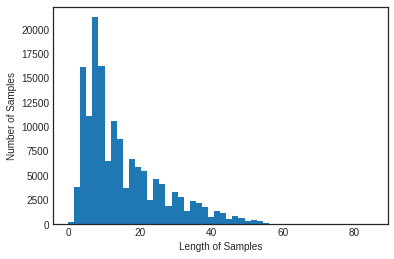

In [212]:
plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [213]:
max_len = 60

In [214]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

#### 모델 구축 및 학습

In [223]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [216]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation = 'sigmoid'))

In [218]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 4, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [220]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(X_train, y_train, epochs = 15, callbacks = [es, mc], batch_size = 64, validation_split=0.2)

Epoch 1/15
1870/1875 [============================>.] - ETA: 0s - loss: 0.2693 - acc: 0.8978
Epoch 1: val_acc improved from -inf to 0.91346, saving model to best_model_h5


1875/1875 [==============================] - 20s 10ms/step - loss: 0.2693 - acc: 0.8978 - val_loss: 0.2361 - val_acc: 0.9135
Epoch 2/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.1961 - acc: 0.9304
Epoch 2: val_acc improved from 0.91346 to 0.91823, saving model to best_model_h5


1875/1875 [==============================] - 17s 9ms/step - loss: 0.1961 - acc: 0.9304 - val_loss: 0.2255 - val_acc: 0.9182
Epoch 3/15
1869/1875 [============================>.] - ETA: 0s - loss: 0.1636 - acc: 0.9424
Epoch 3: val_acc did not improve from 0.91823
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1637 - acc: 0.9423 - val_loss: 0.2327 - val_acc: 0.9159
Epoch 4/15
1870/1875 [============================>.] - ETA: 0s - loss: 0.1377 - acc: 0.9517
Epoch 4: val_acc did not improve from 0.91823
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1376 - acc: 0.9517 - val_loss: 0.2579 - val_acc: 0.9126
Epoch 5/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.1159 - acc: 0.9591
Epoch 5: val_acc did not improve from 0.91823
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1160 - acc: 0.9591 - val_loss: 0.3004 - val_acc: 0.9115
Epoch 6/15
1872/1875 [============================>.] - ETA: 0s - loss: 0.0990 - acc: 0

In [224]:
loaded_model = load_model('best_model_h5')
loaded_model.evaluate(X_test, y_test)

1562/1562 [==============================] - 6s 3ms/step - loss: 0.2227 - acc: 0.9198


[0.22273708879947662, 0.9197831153869629]

#### 시각화

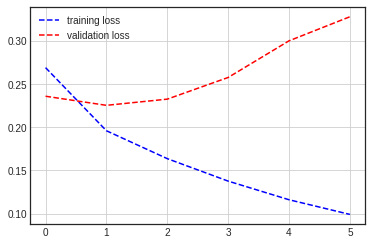

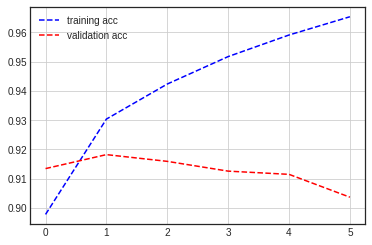

In [225]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label = 'training acc')
plt.plot(val_acc, 'r--', label = 'validation acc')
plt.legend()
plt.grid()

plt.show()

#### 감정 예측

In [228]:
def sentiment_predict(new_sentence):
  new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
  new_sequences = tokenizer.texts_to_sequences([new_token])
  new_pad = pad_sequences(new_sequences, maxlen = max_len)
  score = float(loaded_model.predict(new_pad))

  if score >= 0.6:
    print('{} -> 긍정({:.2f}%)'.format(new_sentence, score*100))
  elif (score >= 0.3) and (score < 0.6):
    print('{} -> 보통({:.2f}%)'.format(new_sentence, score*100))
  else:
    print('{} -> 부정({:.2f}%)'.format(new_sentence, (1 - score)*100))

In [234]:
sentence = [
    '또 구매하고 싶어요 ㅋㅋ',
    '나쁘지않네요 나중에 한번 더 써보고 싶네요~',
    '나쁘지 않아요 ㅋㅋ 한번 써보세요 ㅋㅋ',
    '진짜 언제오냐??',
    '포인트아니면 리뷰 안썼다 진짜',
    '배송이 빨라서 만족!',
    '배송이 너무 느려서 화가 나요',
    '참 이렇게 쓰기 어려운 상품은 처음이네요...',
    '배송을 받았는데 물건이 엉망이네요 택배사를 좀 바꿔야겠어요',
]

for sen in sentence:
  sentiment_predict(sen)

# 문맥 파악을 할 수 있는 모델이 필요하다!

1/1 [==============================] - 0s 17ms/step
또 구매하고 싶어요 ㅋㅋ -> 긍정(96.03%)
1/1 [==============================] - 0s 16ms/step
나쁘지않네요 나중에 한번 더 써보고 싶네요~ -> 보통(41.03%)
1/1 [==============================] - 0s 15ms/step
나쁘지 않아요 ㅋㅋ 한번 써보세요 ㅋㅋ -> 긍정(61.08%)
1/1 [==============================] - 0s 15ms/step
진짜 언제오냐?? -> 부정(77.20%)
1/1 [==============================] - 0s 15ms/step
포인트아니면 리뷰 안썼다 진짜 -> 부정(89.19%)
1/1 [==============================] - 0s 17ms/step
배송이 빨라서 만족! -> 긍정(80.38%)
1/1 [==============================] - 0s 17ms/step
배송이 너무 느려서 화가 나요 -> 부정(98.59%)
1/1 [==============================] - 0s 18ms/step
참 이렇게 쓰기 어려운 상품은 처음이네요... -> 부정(95.40%)
1/1 [==============================] - 0s 23ms/step
배송을 받았는데 물건이 엉망이네요 택배사를 좀 바꿔야겠어요 -> 부정(97.72%)
